# ml03_philip.ipynb
Machine Learning with the Titanic Dataset
Philip Fowler
18 March 2025
This notebook is a simple example of machine learning using the Titanic dataset.
The goal is to predict whether a passenger survived the Titanic disaster based on their attributes.
The dataset is available from the Seaborn library.

In [133]:
# install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from pandas.plotting import scatter_matrix

sns.set_style('whitegrid')


## Section 1. Load and Explore the Data

### 1.1 Load the dataset and display the first 10 rows

In [134]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


what is the difference in pclass vs class?  Can we drop class?
what is the difference between sex and who?  Can we drop who?
Why a separate column for adult male?
Do we ned to keep emarked town?
Is alive the same as survived?
How is alone useful?

survived is the target variable 1=survived, 0=died
pclass is the ticket class 1=1st, 2=2nd, 3=3rd
name, sex, age seem straightforward!
sibsp is the number of siblings/spouses aboard
parch is the number of parents/children aboard
ticket is the ticket number
fare is the passenger fare
cabin is the cabin number
embarked is the port of embarkation C=Cherbourg, Q=Queenstown, S=Southampton

In [135]:
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


### 1.2 Check for missing values and display summary statistics


In [136]:
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Age is likely important and has a lot of missing values.  I will need a strategy to address this.  Not sure about deck.  Can it be dropped?

## Section 2. Visualize Feature Distributions


In [137]:
titanic.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [138]:
titanic.corr(numeric_only=True)

,survived,pclass,age,sibsp,parch,fare,adult_male,alone
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.557080,-0.203367
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.094035,0.135207
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.280328,0.198270
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.253586,-0.584471
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.349943,-0.583398
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182024,-0.271832
adult_male,-0.557080,0.094035,0.280328,-0.253586,-0.349943,-0.182024,1.000000,0.404744
alone,-0.203367,0.135207,0.198270,-0.584471,-0.583398,-0.271832,0.404744,1.000000


The above correlations were done to determine a better way to fill in the missing values for age.  It seems to me that 1st class passengers are likely older than third class passengers.  Thus, perhaps we should fill the missing values for age using the median based on passenger class.

1) How many data instances are there? 891
2) How many features are there? 15
3) What are the names? 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
4) Are there any missing values? Yes, mostly in age and deck.  2 from embark town and embarked
5) Are there any non-numeric features? Yes, sex, embarked, class, who, adult_male, deck, embark_town, alive, alone

6) Are the data instances sorted on any of the attributes? No
7) What are the units of age? Years
8) What are the minimum, median and max age? min: 0.42, median: 28.0, max: 80.0
9) What two different features have the highest correlation?

10) Are there any categorical features that might be useful for prediction? I know a bit about this dataset, so I know that sex and passenger class are important features for predicting survival.

### 2.1 Create histograms, boxplots, and scatterplots


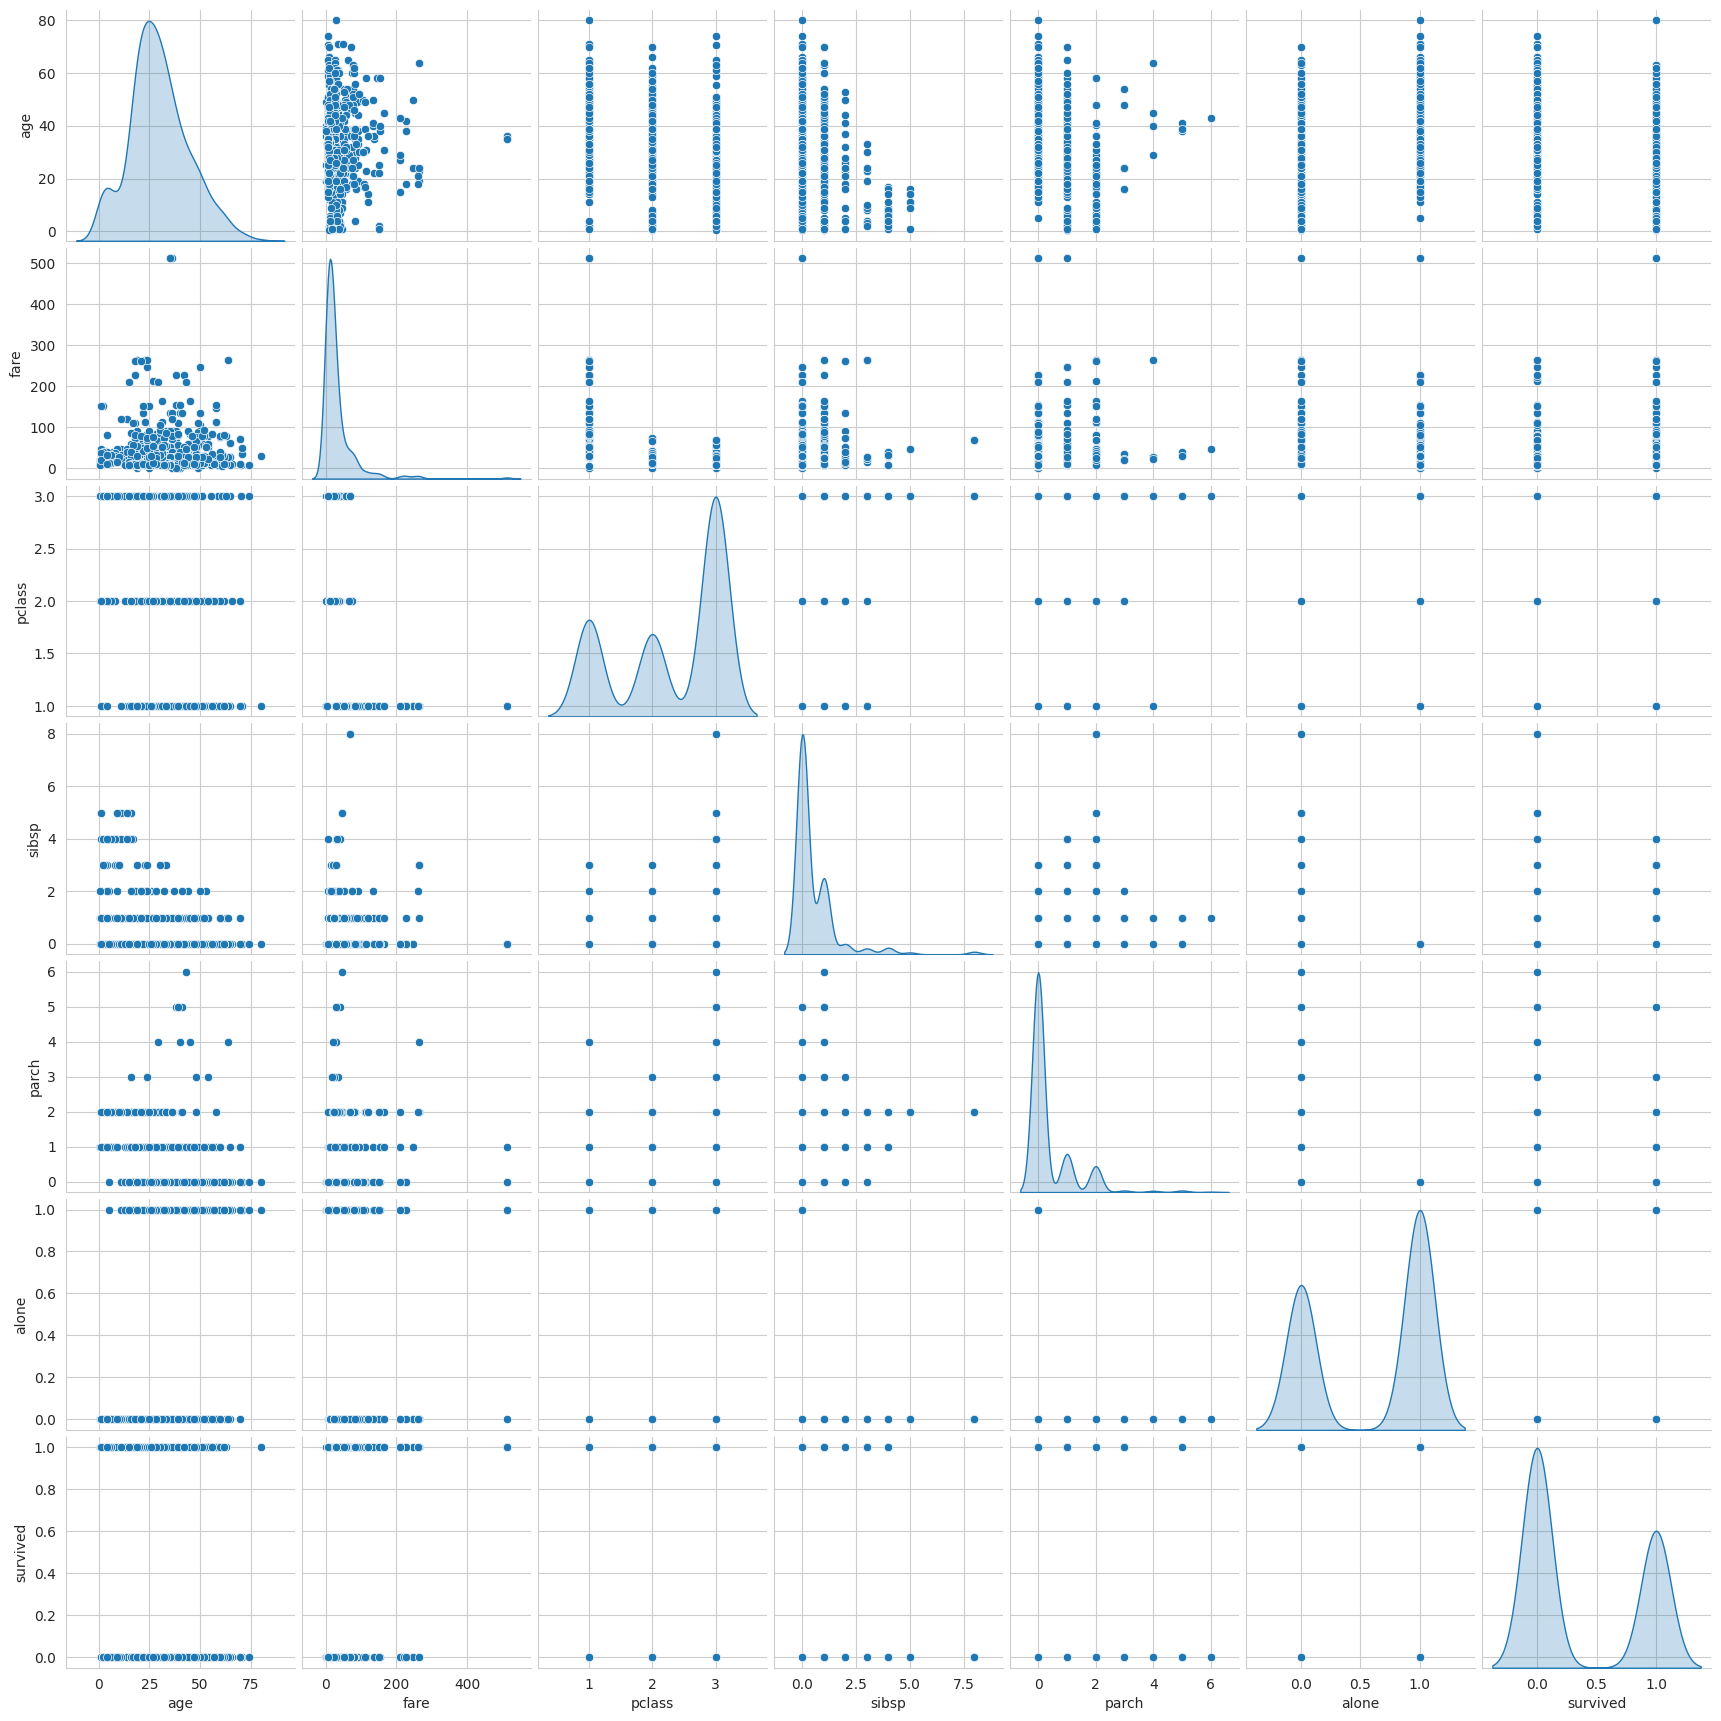

In [139]:
attributes = ['age', 'fare', 'pclass', 'sex', 'sibsp', 'parch', 'alone', 'survived']
sns.pairplot(titanic[attributes], diag_kind='kde')
plt.show()

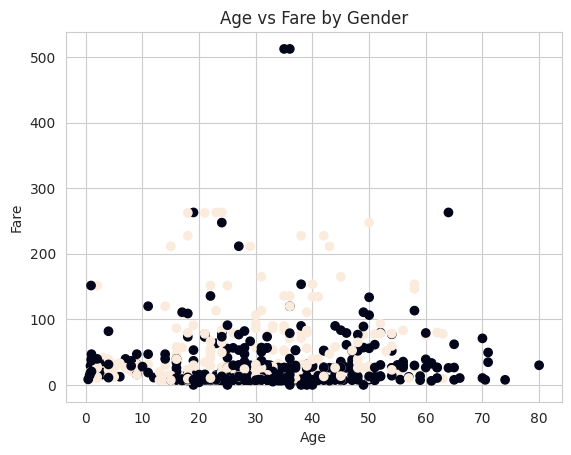

In [140]:
plt.scatter(titanic['age'], titanic['fare'], c=titanic['sex'].apply(lambda x: 0 if x == 'male' else 1))
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender')
plt.show()

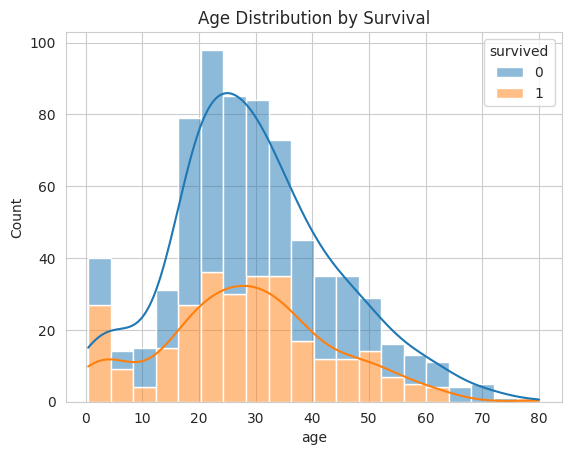

In [141]:
sns.histplot(data=titanic, x='age', hue='survived', kde=True, multiple='stack')
plt.title('Age Distribution by Survival')
plt.show()

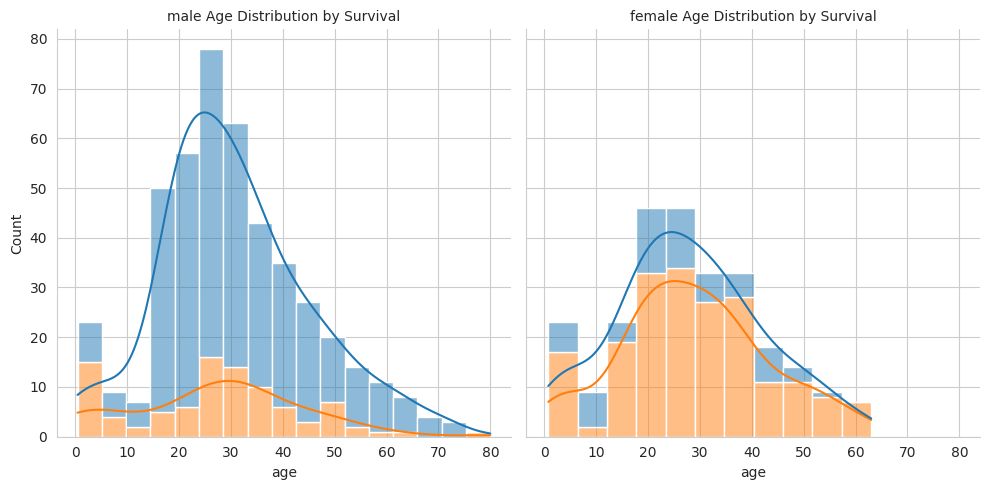

In [142]:
g = sns.FacetGrid(titanic, col="sex", height=5, aspect=1)
g.map(sns.histplot, "age", hue="survived", data=titanic, kde=True, multiple="stack")
g.set_titles("{col_name} Age Distribution by Survival")
plt.show()

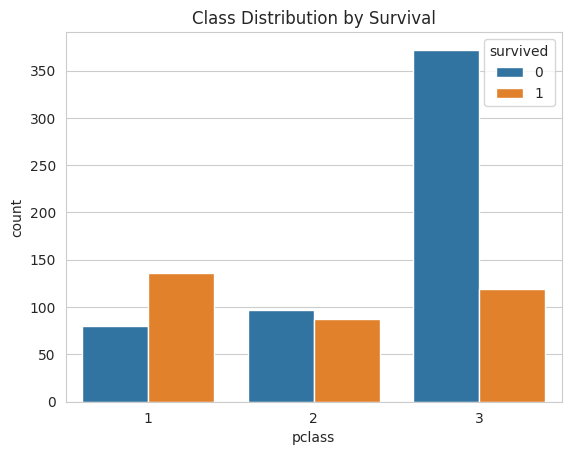

In [143]:
sns.countplot(x='pclass', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()

Reflection 2.1:


1. What patterns or anomalies do you notice? third class passengers are more likely to not survive
2. Do any features stand out as potential predictors? class and sex
3. Are there any visible class imbalances? Yes, in third class passengers

### 2.2 Feature Engineering

In [144]:
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# why are we using embarked town when we have embarked column?
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])


In [145]:
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

titanic['alone'] = titanic['alone'].astype(int)


Reflection 2.3

Why might family size be a useful feature for predicting survival? Perhaps being together with family increased the likelihood of survival.  This would certainly be true for small children.
Why convert categorical data to numeric? It is easier to work with numeric data in machine learning models.



## Section 3. Feature Selection and Justification
### 3.1 Choose input features for predicting the target

In [146]:
# from lab 2
# X = titanic[['age', 'fare', 'pclass', 'sex', 'family_size']]
# y = titanic['survived']

In [150]:
# Define the three cases
cases = {
    'Case 1: alone only': titanic[['alone']],
    'Case 2: age only': titanic[['age']],
    'Case 3: age + family_size': titanic[['age', 'family_size']],
    'Case 4: age + fare + pclass + sex + family_size': titanic[['age', 'fare', 'pclass', 'sex', 'family_size']]
}

# Target variable
y = titanic['survived']

# Iterate through each case and run the models
results = {}

for case_name, X in cases.items():
    # Split the data
    for train_indices, test_indices in splitter.split(X, y):
        X_train = X.iloc[train_indices]
        X_test = X.iloc[test_indices]
        y_train = y.iloc[train_indices]
        y_test = y.iloc[test_indices]

    # Logistic Regression
    logistic_model.fit(X_train, y_train)
    y_pred_logistic = logistic_model.predict(X_test)
    accuracy_log = accuracy_score(y_test, y_pred_logistic)
    precision_log = precision_score(y_test, y_pred_logistic, zero_division=1)
    recall_log = recall_score(y_test, y_pred_logistic)
    f1_log = f1_score(y_test, y_pred_logistic)

    # Decision Tree
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    accuracy_tree = accuracy_score(y_test, y_pred_tree)
    precision_tree = precision_score(y_test, y_pred_tree, zero_division=1)
    recall_tree = recall_score(y_test, y_pred_tree)
    f1_tree = f1_score(y_test, y_pred_tree)

    # SVM (RBF Kernel)
    svm_model_rbf = SVC(kernel='rbf', random_state=dont_panic)
    svm_model_rbf.fit(X_train, y_train)
    y_pred_svm_rbf = svm_model_rbf.predict(X_test)
    accuracy_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
    precision_svm_rbf = precision_score(y_test, y_pred_svm_rbf, zero_division=1)
    recall_svm_rbf = recall_score(y_test, y_pred_svm_rbf)
    f1_svm_rbf = f1_score(y_test, y_pred_svm_rbf)

    # SVM (Linear Kernel)
    svm_model_linear = SVC(kernel='linear', random_state=dont_panic)
    svm_model_linear.fit(X_train, y_train)
    y_pred_svm_linear = svm_model_linear.predict(X_test)
    accuracy_svm_linear = accuracy_score(y_test, y_pred_svm_linear)
    precision_svm_linear = precision_score(y_test, y_pred_svm_linear, zero_division=1)
    recall_svm_linear = recall_score(y_test, y_pred_svm_linear)
    f1_svm_linear = f1_score(y_test, y_pred_svm_linear)

    # SVM (Polynomial Kernel)
    svm_model_poly = SVC(kernel='poly', random_state=dont_panic)
    svm_model_poly.fit(X_train, y_train)
    y_pred_svm_poly = svm_model_poly.predict(X_test)
    accuracy_svm_poly = accuracy_score(y_test, y_pred_svm_poly)
    precision_svm_poly = precision_score(y_test, y_pred_svm_poly, zero_division=1)
    recall_svm_poly = recall_score(y_test, y_pred_svm_poly)
    f1_svm_poly = f1_score(y_test, y_pred_svm_poly)

    # SVM (Sigmoid Kernel)
    svm_model_sigmoid = SVC(kernel='sigmoid', random_state=dont_panic)
    svm_model_sigmoid.fit(X_train, y_train)
    y_pred_svm_sigmoid = svm_model_sigmoid.predict(X_test)
    accuracy_svm_sigmoid = accuracy_score(y_test, y_pred_svm_sigmoid)
    precision_svm_sigmoid = precision_score(y_test, y_pred_svm_sigmoid, zero_division=1)
    recall_svm_sigmoid = recall_score(y_test, y_pred_svm_sigmoid)
    f1_svm_sigmoid = f1_score(y_test, y_pred_svm_sigmoid)

    # Neural Network
    nn_model.fit(X_train, y_train)
    y_pred_nn = nn_model.predict(X_test)
    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    precision_nn = precision_score(y_test, y_pred_nn, zero_division=1)
    recall_nn = recall_score(y_test, y_pred_nn)
    f1_nn = f1_score(y_test, y_pred_nn)

    # Store results
    results[case_name] = {
        'Logistic Regression': {
            'Accuracy': accuracy_log,
            'Precision': precision_log,
            'Recall': recall_log,
            'F1': f1_log
        },
        'Decision Tree': {
            'Accuracy': accuracy_tree,
            'Precision': precision_tree,
            'Recall': recall_tree,
            'F1': f1_tree
        },
        'SVM (RBF Kernel)': {
            'Accuracy': accuracy_svm_rbf,
            'Precision': precision_svm_rbf,
            'Recall': recall_svm_rbf,
            'F1': f1_svm_rbf
        },
        'SVM (Linear Kernel)': {
            'Accuracy': accuracy_svm_linear,
            'Precision': precision_svm_linear,
            'Recall': recall_svm_linear,
            'F1': f1_svm_linear
        },
        'SVM (Polynomial Kernel)': {
            'Accuracy': accuracy_svm_poly,
            'Precision': precision_svm_poly,
            'Recall': recall_svm_poly,
            'F1': f1_svm_poly
        },
        'SVM (Sigmoid Kernel)': {
            'Accuracy': accuracy_svm_sigmoid,
            'Precision': precision_svm_sigmoid,
            'Recall': recall_svm_sigmoid,
            'F1': f1_svm_sigmoid
        },
        'Neural Network': {
            'Accuracy': accuracy_nn,
            'Precision': precision_nn,
            'Recall': recall_nn,
            'F1': f1_nn
        }
    }

# Print results
for case_name, case_results in results.items():
    print(f"Results for {case_name}:")
    for model_name, metrics in case_results.items():
        print(f"  {model_name}:")
        for metric_name, value in metrics.items():
            print(f"    {metric_name}: {value}")
    print()

/home/philip/nwmissouri/applied-ml-philip/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Results for Case 1: alone only:
  Logistic Regression:
    Accuracy: 0.5921787709497207
    Precision: 0.47368421052631576
    Recall: 0.5217391304347826
    F1: 0.496551724137931
  Decision Tree:
    Accuracy: 0.5921787709497207
    Precision: 0.47368421052631576
    Recall: 0.5217391304347826
    F1: 0.496551724137931
  SVM (RBF Kernel):
    Accuracy: 0.5921787709497207
    Precision: 0.47368421052631576
    Recall: 0.5217391304347826
    F1: 0.496551724137931
  SVM (Linear Kernel):
    Accuracy: 0.5921787709497207
    Precision: 0.47368421052631576
    Recall: 0.5217391304347826
    F1: 0.496551724137931
  SVM (Polynomial Kernel):
    Accuracy: 0.5921787709497207
    Precision: 0.47368421052631576
    Recall: 0.5217391304347826
    F1: 0.496551724137931
  SVM (Sigmoid Kernel):
    Accuracy: 0.5921787709497207
    Precision: 0.47368421052631576
    Recall: 0.5217391304347826
    F1: 0.496551724137931
  Neural Network:
    Accuracy: 0.5921787709497207
    Precision: 0.4736842105263157

/home/philip/nwmissouri/applied-ml-philip/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


| Model Type | Case | Features Used | Accuracy | Precision | Recall | F1-Score | Notes |
|------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Decision Tree** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (RBF Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Linear Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Poly Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Sigmoid Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Neural Network (MLP)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |

In [151]:
# Create a list to store the results
results_list = []

# Iterate through the results dictionary and extract the required information
for case_name, case_results in results.items():
    features_used = cases[case_name].columns.tolist()
    for model_name, metrics in case_results.items():
        results_list.append({
            'Model': model_name,
            'Case': case_name,
            'Features Used': ', '.join(features_used),
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1 Score': metrics['F1']
        })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)


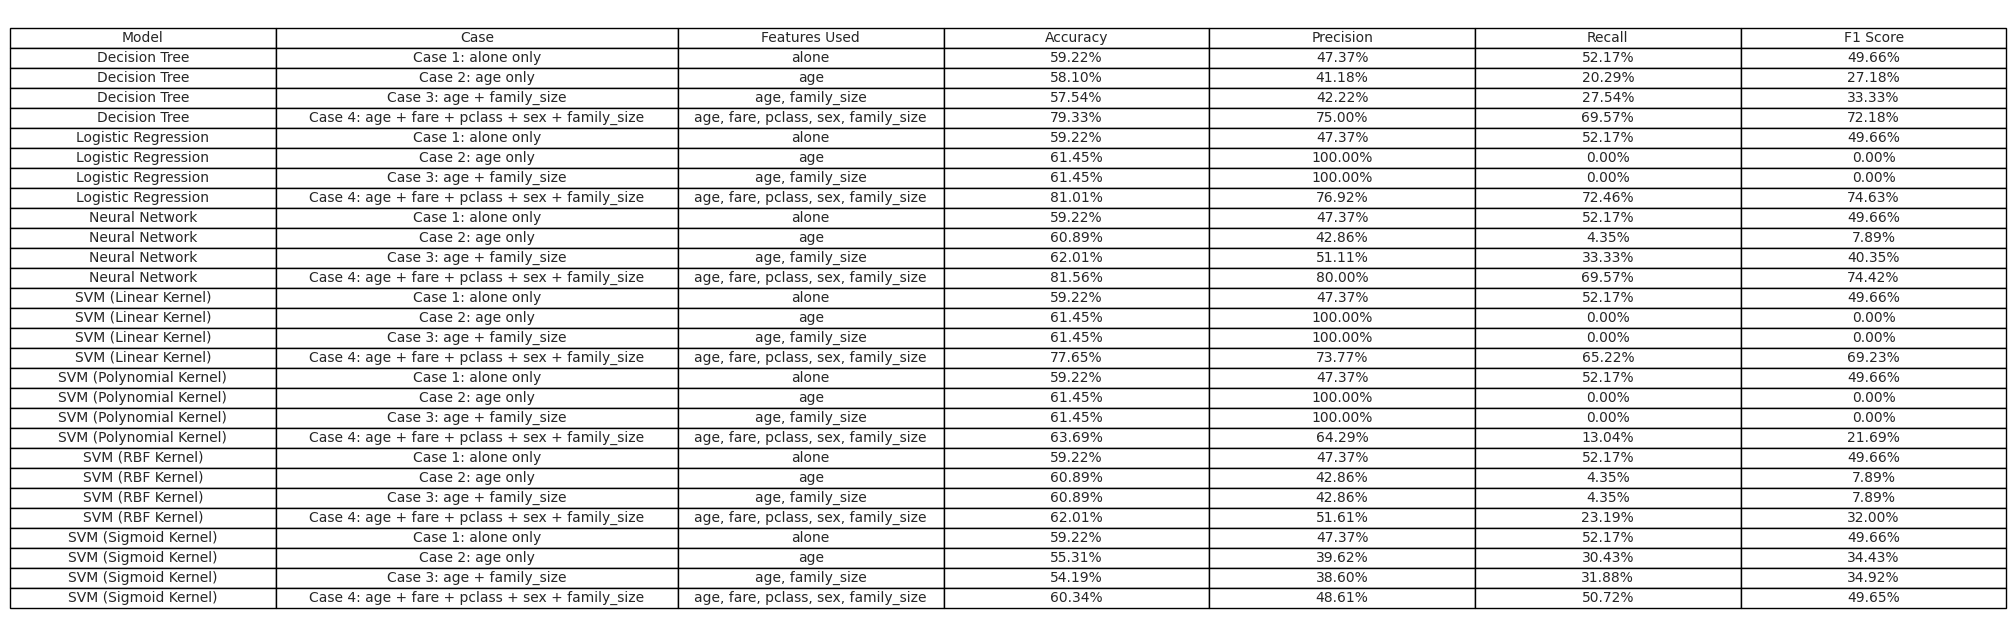

In [155]:
# Sort the DataFrame by 'Model' and then by 'Case'
sorted_results_df = results_df.sort_values(by=['Model', 'Case'])

# Extract the data from the sorted results DataFrame
table_data = sorted_results_df[['Model', 'Case', 'Features Used', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].values

# Format the values as percentages limited to two decimal places
table_data = [[f'{value:.2%}' if isinstance(value, float) else value for value in row] for row in table_data]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 8))

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=table_data, colLabels=['Model', 'Case', 'Features Used', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], cellLoc='center', loc='center')

# Adjust the table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Adjust column widths
table.auto_set_column_width([1])  # Set the width of the 'Case' column

# Display the table
plt.show()

#save the table as an image
fig.savefig('results_table.png', dpi=300, bbox_inches='tight')

| Model Type | Case | Features Used | Accuracy | Precision | Recall | F1-Score | Notes |
|------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Decision Tree** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (RBF Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Linear Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Poly Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Sigmoid Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Neural Network (MLP)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |

Reflection 3:

Why are these features selected? These are the features that appear to be the best for predicting survival.
Are there any features that are likely to be highly predictive of survival? 

## Section 4. Train a Model (everything below has been deprecated)
### 4.1 Split the data


In [102]:
dont_panic = 42
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=dont_panic)

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

print('Train size: ', len(X_train), 'Test size: ', len(X_test))

Train size:  712 Test size:  179


Reflection 4:

Why might stratification improve model performance?  Stratification ensures that the train and test sets have the same class percentages.  
How close are the training and test distributions to the original dataset? The training and test sets are very close to the original dataset.  The class percentages are almost identical.
Which split method produced better class balance? Stratified split

### 4.2 Train the models


In [119]:
# Create the logistic model
logistic_model = LogisticRegression(max_iter=1000, random_state=dont_panic)

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
accuracy_log = accuracy_score(y_test, y_pred_logistic)
precision_log = precision_score(y_test, y_pred_logistic)
recall_log = recall_score(y_test, y_pred_logistic)
f1_log = f1_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
class_report = classification_report(y_test, y_pred_logistic)

print(f'Accuracy: {accuracy_log}')
print(f'Precision: {precision_log}')
print(f'Recall: {recall_log}')
print(f'F1: {f1_log}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.5921787709497207
Precision: 0.47368421052631576
Recall: 0.5217391304347826
F1: 0.496551724137931
Confusion Matrix:
[[70 40]
 [33 36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       110
           1       0.47      0.52      0.50        69

    accuracy                           0.59       179
   macro avg       0.58      0.58      0.58       179
weighted avg       0.60      0.59      0.60       179



In [104]:
# Create the decision tree model
tree_model = DecisionTreeClassifier()

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_train)

# Evaluate the model
accuracy_tree = accuracy_score(y_train, y_pred_tree)
precision_tree = precision_score(y_train, y_pred_tree)
recall_tree = recall_score(y_train, y_pred_tree)
f1_tree = f1_score(y_train, y_pred_tree)
conf_matrix = confusion_matrix(y_train, y_pred_tree)
class_report = classification_report(y_train, y_pred_tree)

print(f'Accuracy: {accuracy_tree}')
print(f'Precision: {precision_tree}')
print(f'Recall: {recall_tree}')
print(f'F1: {f1_tree}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.6278089887640449
Precision: 0.5143884892086331
Recall: 0.5238095238095238
F1: 0.5190562613430127
Confusion Matrix:
[[304 135]
 [130 143]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       439
           1       0.51      0.52      0.52       273

    accuracy                           0.63       712
   macro avg       0.61      0.61      0.61       712
weighted avg       0.63      0.63      0.63       712



In [105]:
# Create the SVM model
svm_model = SVC(kernel='rbf', random_state=dont_panic)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_train)

# Evaluate the model
accuracy_svm_rbf = accuracy_score(y_train, y_pred_svm)
precision_svm_rbf = precision_score(y_train, y_pred_svm)
recall_svm_rbf = recall_score(y_train, y_pred_svm)
f1_svm_rbf = f1_score(y_train, y_pred_svm)  
conf_matrix = confusion_matrix(y_train, y_pred_svm)
class_report = classification_report(y_train, y_pred_svm)

print(f'Accuracy: {accuracy_svm_rbf}')
print(f'Precision: {precision_svm_rbf}')
print(f'Recall: {recall_svm_rbf}')
print(f'F1: {f1_svm_rbf}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.6278089887640449
Precision: 0.5143884892086331
Recall: 0.5238095238095238
F1: 0.5190562613430127
Confusion Matrix:
[[304 135]
 [130 143]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       439
           1       0.51      0.52      0.52       273

    accuracy                           0.63       712
   macro avg       0.61      0.61      0.61       712
weighted avg       0.63      0.63      0.63       712



In [120]:
# Create the SVM model with linear kernel
svm_model = SVC(kernel='linear', random_state=dont_panic)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_train)

# Evaluate the model
accuracy_svm_linear = accuracy_score(y_train, y_pred_svm)
precision_svm_linear = precision_score(y_train, y_pred_svm)
recall_svm_linear = recall_score(y_train, y_pred_svm)
f1_svm_linear = f1_score(y_train, y_pred_svm)  
conf_matrix = confusion_matrix(y_train, y_pred_svm)
class_report = classification_report(y_train, y_pred_svm)

print(f'Accuracy: {accuracy_svm_linear}')
print(f'Precision: {precision_svm_linear}')
print(f'Recall: {recall_svm_linear}')
print(f'F1: {f1_svm_linear}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.6278089887640449
Precision: 0.5143884892086331
Recall: 0.5238095238095238
F1: 0.5190562613430127
Confusion Matrix:
[[304 135]
 [130 143]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       439
           1       0.51      0.52      0.52       273

    accuracy                           0.63       712
   macro avg       0.61      0.61      0.61       712
weighted avg       0.63      0.63      0.63       712



In [122]:
# Create the SVM model with polynomial kernel
svm_model = SVC(kernel='poly', random_state=dont_panic)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_train)

# Evaluate the model
accuracy_svm_poly = accuracy_score(y_train, y_pred_svm)
precision_svm_poly = precision_score(y_train, y_pred_svm)
recall_svm_poly = recall_score(y_train, y_pred_svm)
f1_svm_poly = f1_score(y_train, y_pred_svm)  
conf_matrix = confusion_matrix(y_train, y_pred_svm)
class_report = classification_report(y_train, y_pred_svm)

print(f'Accuracy: {accuracy_svm_poly}')
print(f'Precision: {precision_svm_poly}')
print(f'Recall: {recall_svm_poly}')
print(f'F1: {f1_svm_poly}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.6278089887640449
Precision: 0.5143884892086331
Recall: 0.5238095238095238
F1: 0.5190562613430127
Confusion Matrix:
[[304 135]
 [130 143]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       439
           1       0.51      0.52      0.52       273

    accuracy                           0.63       712
   macro avg       0.61      0.61      0.61       712
weighted avg       0.63      0.63      0.63       712



In [123]:
# Create the SVM model with sigmoid kernel
svm_model = SVC(kernel='sigmoid', random_state=dont_panic)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_train)

# Evaluate the model
accuracy_svm_sigmoid = accuracy_score(y_train, y_pred_svm)
precision_svm_sigmoid = precision_score(y_train, y_pred_svm)
recall_svm_sigmoid = recall_score(y_train, y_pred_svm)
f1_svm_sigmoid = f1_score(y_train, y_pred_svm)  
conf_matrix = confusion_matrix(y_train, y_pred_svm)
class_report = classification_report(y_train, y_pred_svm)

print(f'Accuracy: {accuracy_svm_sigmoid}')
print(f'Precision: {precision_svm_sigmoid}')
print(f'Recall: {recall_svm_sigmoid}')
print(f'F1: {f1_svm_sigmoid}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.6278089887640449
Precision: 0.5143884892086331
Recall: 0.5238095238095238
F1: 0.5190562613430127
Confusion Matrix:
[[304 135]
 [130 143]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       439
           1       0.51      0.52      0.52       273

    accuracy                           0.63       712
   macro avg       0.61      0.61      0.61       712
weighted avg       0.63      0.63      0.63       712



In [124]:
# Create the neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs', random_state=dont_panic)

# Train the model
nn_model.fit(X_train, y_train)

# Make predictions
y_pred_nn = nn_model.predict(X_train)

# Evaluate the model
accuracy_nn = accuracy_score(y_train, y_pred_nn)
precision_nn = precision_score(y_train, y_pred_nn)
recall_nn = recall_score(y_train, y_pred_nn)
f1_nn = f1_score(y_train, y_pred_nn)
conf_matrix = confusion_matrix(y_train, y_pred_nn)
class_report = classification_report(y_train, y_pred_nn)    

print(f'Accuracy: {accuracy_nn}')
print(f'Precision: {precision_nn}')
print(f'Recall: {recall_nn}')
print(f'F1: {f1_nn}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.6278089887640449
Precision: 0.5143884892086331
Recall: 0.5238095238095238
F1: 0.5190562613430127
Confusion Matrix:
[[304 135]
 [130 143]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       439
           1       0.51      0.52      0.52       273

    accuracy                           0.63       712
   macro avg       0.61      0.61      0.61       712
weighted avg       0.63      0.63      0.63       712



### 4.3 Report R^2, MAE, RMSE
Evaluate the model using R^2, MAE, and RMSE.

In [107]:
# Logistic Regression R2 score
r2_logistic = r2_score(y_test, y_pred_logistic)
print(f'R² score: {r2_logistic}')

R² score: -0.721607378129117


In [108]:
# Decision Tree R2 score
r2_tree = r2_score(y_train, y_pred_tree)
print(f'R² score: {r2_tree}')

R² score: -0.5743406176208001


In [109]:
# SVM R2 score
r2_svm = r2_score(y_train, y_pred_svm)
print(f'R² score: {r2_svm}')

R² score: -0.5743406176208001


In [110]:
# Neural Network R2 score
r2_nn = r2_score(y_train, y_pred_nn)    
print(f'R² score: {r2_nn}')

R² score: -0.5743406176208001


In [111]:
# Logistic Regression Mean Squared Error
mae_logistic = mean_absolute_error(y_test, y_pred_logistic)
print(f'Mean Absolute Error (MAE): {mae_logistic}')

Mean Absolute Error (MAE): 0.40782122905027934


In [112]:
# Decision Tree Mean Squared Error
mae_tree = mean_absolute_error(y_train, y_pred_tree)
print(f'Mean Absolute Error (MAE): {mae_tree}')

Mean Absolute Error (MAE): 0.37219101123595505


In [113]:
# SVM Mean Squared Error
mae_svm = mean_absolute_error(y_train, y_pred_svm)
print(f'Mean Absolute Error (MAE): {mae_svm}')

Mean Absolute Error (MAE): 0.37219101123595505


In [114]:
# Neural Network Mean Squared Error
mae_nn = mean_absolute_error(y_train, y_pred_nn)
print(f'Mean Absolute Error (MAE): {mae_nn}')

Mean Absolute Error (MAE): 0.37219101123595505


In [115]:
# Logistic Regression Root Mean Squared Error
rmse_logistic = np.sqrt(mean_squared_error(y_test, y_pred_logistic))
print(f'Root Mean Squared Error (RMSE): {rmse_logistic}')

Root Mean Squared Error (RMSE): 0.6386088231854297


In [116]:
# Decision Tree Root Mean Squared Error
rmse_tree = np.sqrt(mean_squared_error(y_train, y_pred_tree))
print(f'Root Mean Squared Error (RMSE): {rmse_tree}')

Root Mean Squared Error (RMSE): 0.6100745948127615


In [117]:
# SVM Root Mean Squared Error
rmse_svm = np.sqrt(mean_squared_error(y_train, y_pred_svm))
print(f'Root Mean Squared Error (RMSE): {rmse_svm}')

Root Mean Squared Error (RMSE): 0.6100745948127615


In [118]:
# Neural Network Root Mean Squared Error
rmse_nn = np.sqrt(mean_squared_error(y_train, y_pred_nn))
print(f'Root Mean Squared Error (RMSE): {rmse_nn}')

Root Mean Squared Error (RMSE): 0.6100745948127615


## Section 5. Evaluate the Models
### 5.1 Compare the models

| Model Type | Case | Features Used | Accuracy | Precision | Recall | F1-Score | Notes |
|------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Decision Tree** | Case 1 | alone | 62.78% | 51.43% | 52.38% | 51.91% | - |
|                   | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (RBF Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Linear Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Poly Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Sigmoid Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Neural Network (MLP)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |